
# Q learning (Q-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    #     print('state, action, reward, done, info')
    #     print(state, action, reward, done, info)
    if done:
    #         print('state, action, reward, done, info')
    #         print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Current actions given
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Qs = qs+ (gamma * nextQs)/values/logits
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs')
    
    # returning the given data to the model
    return states, actions, nextQs

In [7]:
# Q: Qfunction/Encoder/Classifier
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('qfunction', reuse=reuse):        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [8]:
def model_loss(states,  actions, nextQs, gamma, # model input data 
               action_size, hidden_size): # model init
    # Calculating Qs total rewards
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_mask = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_masked = tf.multiply(actions_logits, actions_mask)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # Current reward or Rt/rt
    # Calculating rewards/Rs as prob/sigmoid of Qs, i.e. between 0-1
    qs = tf.sigmoid(Qs) # qt
    
    # Bellman equaion for calculating total rewards using current reward + total future rewards/nextQs
    #targetQs = qs + (0.99 * nextQs)
    targetQs = qs + (gamma * nextQs)
    
    # Calculating the loss: logits/predictions vs labels
    q_loss = tf.reduce_mean(tf.square(Qs - targetQs))

    return actions_logits, q_loss, qs, Qs

In [9]:
def model_opt(q_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)

    return q_opt

In [10]:
class QGAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.nextQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss, self.qs, self.Qs = model_loss(
            action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init parameters
            states=self.states, actions=self.actions, nextQs=self.nextQs) # model input data

        # Update the model: backward pass and backprop
        self.q_opt = model_opt(q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [11]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [13]:
train_episodes = 2500          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [14]:
tf.reset_default_graph()

model = QGAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate, 
             gamma=gamma)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [15]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [16]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
q_loss_list = []
mean_qs_list, std_qs_list = [], []
mean_Qs_list, std_Qs_list = [], []
mean_nextQs_list, std_nextQs_list = [], []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    #     # Restore/load the trained model 
    #     #saver.restore(sess, 'checkpoints/model.ckpt')    
    #     saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        q_loss = 0
        mean_qs, std_qs = 0, 0
        mean_Qs, std_Qs = 0, 0
        mean_nextQs, std_nextQs = 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training mean qs: {:.4f}'.format(np.mean(qs)),
                      'Training std qs: {:.4f}'.format(np.std(qs)),
                      'Training mean Qs: {:.4f}'.format(np.mean(Qs)),
                      'Training std Qs: {:.4f}'.format(np.std(Qs)),
                      'Training mean nextQs: {:.4f}'.format(np.mean(nextQs)),
                      'Training std nextQs: {:.4f}'.format(np.std(nextQs)),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                q_loss_list.append((ep, q_loss))
                mean_qs_list.append((ep, np.mean(qs)))
                std_qs_list.append((ep, np.std(qs)))
                mean_Qs_list.append((ep, np.mean(Qs)))
                std_Qs_list.append((ep, np.std(Qs)))
                mean_nextQs_list.append((ep, np.mean(nextQs)))
                std_nextQs_list.append((ep, np.std(nextQs)))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1) # boolean

            # Calculating nextQt/future rewards: Qt = Rs + (gamma * nextQs)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)            
            next_actions_mask = (1 - episode_ends.astype(next_actions_logits.dtype)).reshape(-1, 1) 
            #nextQs = next_actions_logits * next_actions_mask
            nextQs_masked = np.multiply(next_actions_logits, next_actions_mask)
            nextQs = np.max(nextQs_masked, axis=1)

            # Updating the model
            feed_dict = {model.states: states, model.actions: actions, model.nextQs: nextQs}
            Qs, qs, q_loss, _ = sess.run([model.Qs, model.qs, model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 2.0 Training mean qs: 0.5149 Training std qs: 0.0215 Training mean Qs: 0.0598 Training std Qs: 0.0863 Training mean nextQs: 0.1153 Training std nextQs: 0.0945 Training q_loss: 0.3314 Explore P: 0.9998
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 13.0 Training mean qs: 0.5915 Training std qs: 0.0954 Training mean Qs: 0.3900 Training std Qs: 0.4198 Training mean nextQs: 0.6987 Training std nextQs: 0.3584 Training q_loss: 0.9749 Explore P: 0.9985
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 20.0 Training mean qs: 0.7568 Training std qs: 0.1404 Training mean Qs: 1.3574 Training std Qs: 0.9794 Training mean nextQ

-------------------------------------------------------------------------------
Episode: 22 Total reward: 26.0 Training mean qs: 0.9999 Training std qs: 0.0004 Training mean Qs: 56.9854 Training std Qs: 20.0458 Training mean nextQs: 57.1599 Training std nextQs: 21.8498 Training q_loss: 65.3290 Explore P: 0.9510
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 23 Total reward: 24.0 Training mean qs: 1.0000 Training std qs: 0.0001 Training mean Qs: 59.3053 Training std Qs: 18.0747 Training mean nextQs: 59.1356 Training std nextQs: 20.7964 Training q_loss: 79.5414 Explore P: 0.9487
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 24 Total reward: 15.0 Training mean qs: 0.9991 Training std qs: 0.0129 Training mean Qs: 57.2681 Training std Qs: 19.2411 Tra

-------------------------------------------------------------------------------
Episode: 43 Total reward: 20.0 Training mean qs: 1.0000 Training std qs: 0.0000 Training mean Qs: 91.7052 Training std Qs: 24.5524 Training mean nextQs: 92.5416 Training std nextQs: 27.5416 Training q_loss: 87.6615 Explore P: 0.9061
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 44 Total reward: 26.0 Training mean qs: 1.0000 Training std qs: 0.0000 Training mean Qs: 93.9186 Training std Qs: 22.1207 Training mean nextQs: 95.2191 Training std nextQs: 25.4748 Training q_loss: 136.1965 Explore P: 0.9038
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 45 Total reward: 21.0 Training mean qs: 0.9999 Training std qs: 0.0020 Training mean Qs: 94.4350 Training std Qs: 26.0133 Tr

-------------------------------------------------------------------------------
Episode: 65 Total reward: 56.0 Training mean qs: 0.9950 Training std qs: 0.0497 Training mean Qs: 319.6225 Training std Qs: 93.3024 Training mean nextQs: 323.0450 Training std nextQs: 99.5508 Training q_loss: 505.5561 Explore P: 0.8472
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 66 Total reward: 14.0 Training mean qs: 0.9975 Training std qs: 0.0353 Training mean Qs: 320.5163 Training std Qs: 96.7500 Training mean nextQs: 327.0399 Training std nextQs: 101.6773 Training q_loss: 881.6055 Explore P: 0.8461
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 67 Total reward: 12.0 Training mean qs: 0.9975 Training std qs: 0.0353 Training mean Qs: 343.0559 Training std Qs: 96.

-------------------------------------------------------------------------------
Episode: 86 Total reward: 43.0 Training mean qs: 0.9975 Training std qs: 0.0353 Training mean Qs: 4634.7056 Training std Qs: 1355.0461 Training mean nextQs: 4664.9019 Training std nextQs: 1479.5409 Training q_loss: 161629.9375 Explore P: 0.7723
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 87 Total reward: 14.0 Training mean qs: 0.9925 Training std qs: 0.0608 Training mean Qs: 4619.5840 Training std Qs: 1409.8717 Training mean nextQs: 4636.1211 Training std nextQs: 1575.0591 Training q_loss: 208629.2344 Explore P: 0.7712
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 88 Total reward: 21.0 Training mean qs: 0.9950 Training std qs: 0.0497 Training mean Qs: 4416.9380 Tr

-------------------------------------------------------------------------------
Episode: 107 Total reward: 48.0 Training mean qs: 0.9950 Training std qs: 0.0497 Training mean Qs: 24984.4570 Training std Qs: 6878.3096 Training mean nextQs: 25171.9668 Training std nextQs: 7721.6089 Training q_loss: 4198337.5000 Explore P: 0.7054
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 108 Total reward: 45.0 Training mean qs: 0.9925 Training std qs: 0.0608 Training mean Qs: 27634.7656 Training std Qs: 7328.1035 Training mean nextQs: 27957.4395 Training std nextQs: 8086.9253 Training q_loss: 5690860.0000 Explore P: 0.7023
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 109 Total reward: 27.0 Training mean qs: 0.9975 Training std qs: 0.0353 Training mean Qs: 276

-------------------------------------------------------------------------------
Episode: 127 Total reward: 83.0 Training mean qs: 0.9950 Training std qs: 0.0497 Training mean Qs: 155945.6875 Training std Qs: 38418.5469 Training mean nextQs: 157731.5781 Training std nextQs: 41797.8828 Training q_loss: 90169248.0000 Explore P: 0.5927
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 128 Total reward: 159.0 Training mean qs: 0.9975 Training std qs: 0.0353 Training mean Qs: 173030.1406 Training std Qs: 39466.6055 Training mean nextQs: 176458.1406 Training std nextQs: 38553.9844 Training q_loss: 29453696.0000 Explore P: 0.5835
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 129 Total reward: 48.0 Training mean qs: 0.9900 Training std qs: 0.0700 Training m

-------------------------------------------------------------------------------
Episode: 147 Total reward: 199.0 Training mean qs: 1.0000 Training std qs: 0.0000 Training mean Qs: 456258.5625 Training std Qs: 80851.8359 Training mean nextQs: 459272.0000 Training std nextQs: 97760.2344 Training q_loss: 1172555648.0000 Explore P: 0.4943
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 148 Total reward: 199.0 Training mean qs: 0.9950 Training std qs: 0.0497 Training mean Qs: 468857.8438 Training std Qs: 117146.1016 Training mean nextQs: 471106.3125 Training std nextQs: 131206.2500 Training q_loss: 1204739712.0000 Explore P: 0.4848
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 149 Total reward: 68.0 Training mean qs: 0.9975 Training std qs: 0.0353 Tra

-------------------------------------------------------------------------------
Episode: 167 Total reward: 178.0 Training mean qs: 0.9975 Training std qs: 0.0353 Training mean Qs: 743129.7500 Training std Qs: 158612.9375 Training mean nextQs: 746932.6250 Training std nextQs: 177064.2500 Training q_loss: 4019807488.0000 Explore P: 0.3622
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 168 Total reward: 199.0 Training mean qs: 0.9975 Training std qs: 0.0353 Training mean Qs: 736133.1875 Training std Qs: 162611.1406 Training mean nextQs: 744236.3750 Training std nextQs: 166832.6250 Training q_loss: 862558272.0000 Explore P: 0.3552
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 169 Total reward: 199.0 Training mean qs: 1.0000 Training std qs: 0.0000 T

-------------------------------------------------------------------------------
Episode: 187 Total reward: 199.0 Training mean qs: 0.9725 Training std qs: 0.1140 Training mean Qs: 519567.5312 Training std Qs: 173319.6094 Training mean nextQs: 519349.9062 Training std nextQs: 199799.5781 Training q_loss: 2173183488.0000 Explore P: 0.2510
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 188 Total reward: 199.0 Training mean qs: 0.9875 Training std qs: 0.0781 Training mean Qs: 528987.2500 Training std Qs: 145832.0000 Training mean nextQs: 531638.8125 Training std nextQs: 163846.5625 Training q_loss: 1030416960.0000 Explore P: 0.2463
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 189 Total reward: 199.0 Training mean qs: 0.9525 Training std qs: 0.1466 

-------------------------------------------------------------------------------
Episode: 207 Total reward: 199.0 Training mean qs: 0.9375 Training std qs: 0.1654 Training mean Qs: 240267.3594 Training std Qs: 110589.3125 Training mean nextQs: 210584.9062 Training std nextQs: 203025.8750 Training q_loss: 14384706560.0000 Explore P: 0.1729
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 208 Total reward: 199.0 Training mean qs: 0.9075 Training std qs: 0.1941 Training mean Qs: 191715.9219 Training std Qs: 115365.0312 Training mean nextQs: 162657.0156 Training std nextQs: 186807.1250 Training q_loss: 10048911360.0000 Explore P: 0.1697
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 209 Total reward: 199.0 Training mean qs: 0.9450 Training std qs: 0.156

-------------------------------------------------------------------------------
Episode: 227 Total reward: 199.0 Training mean qs: 0.8250 Training std qs: 0.2385 Training mean Qs: 37379.7891 Training std Qs: 30205.2988 Training mean nextQs: -21289.7246 Training std nextQs: 150443.6562 Training q_loss: 20319733760.0000 Explore P: 0.1194
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 228 Total reward: 199.0 Training mean qs: 0.8125 Training std qs: 0.2421 Training mean Qs: 32626.7148 Training std Qs: 29731.3574 Training mean nextQs: -33000.3594 Training std nextQs: 170641.4844 Training q_loss: 27678580736.0000 Explore P: 0.1173
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 229 Total reward: 199.0 Training mean qs: 0.8450 Training std qs: 0.2312 Tr

-------------------------------------------------------------------------------
Episode: 247 Total reward: 199.0 Training mean qs: 0.6725 Training std qs: 0.2377 Training mean Qs: 1774.3910 Training std Qs: 2906.1694 Training mean nextQs: -62074.7734 Training std nextQs: 156527.8594 Training q_loss: 27778222080.0000 Explore P: 0.0839
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 248 Total reward: 199.0 Training mean qs: 0.6675 Training std qs: 0.2360 Training mean Qs: 1216.0054 Training std Qs: 2189.4971 Training mean nextQs: -53125.6055 Training std nextQs: 115049.2031 Training q_loss: 15732809728.0000 Explore P: 0.0825
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 249 Total reward: 199.0 Training mean qs: 0.7050 Training std qs: 0.2459 Traini

-------------------------------------------------------------------------------
Episode: 267 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -77769.8672 Training std nextQs: 116407.5938 Training q_loss: 19208783872.0000 Explore P: 0.0596
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 268 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -109404.9531 Training std nextQs: 190925.8906 Training q_loss: 47458430976.0000 Explore P: 0.0587
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 269 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs:

-------------------------------------------------------------------------------
Episode: 287 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -95746.3594 Training std nextQs: 156258.9219 Training q_loss: 32915795968.0000 Explore P: 0.0433
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 288 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -89695.3984 Training std nextQs: 124344.2422 Training q_loss: 23038883840.0000 Explore P: 0.0427
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 289 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 

-------------------------------------------------------------------------------
Episode: 307 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -100328.6094 Training std nextQs: 161869.2188 Training q_loss: 35545657344.0000 Explore P: 0.0324
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 308 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -92474.2891 Training std nextQs: 146362.3125 Training q_loss: 29376858112.0000 Explore P: 0.0320
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 309 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs:

-------------------------------------------------------------------------------
Episode: 327 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -109975.3203 Training std nextQs: 125692.1250 Training q_loss: 27337900032.0000 Explore P: 0.0250
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 328 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -83806.4922 Training std nextQs: 115773.0391 Training q_loss: 20020348928.0000 Explore P: 0.0247
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 329 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs:

-------------------------------------------------------------------------------
Episode: 347 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -99846.7578 Training std nextQs: 150369.7812 Training q_loss: 31931994112.0000 Explore P: 0.0201
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 348 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -110706.0312 Training std nextQs: 130084.4609 Training q_loss: 28597045248.0000 Explore P: 0.0199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 349 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs:

-------------------------------------------------------------------------------
Episode: 367 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -115344.9219 Training std nextQs: 115791.0625 Training q_loss: 26180339712.0000 Explore P: 0.0168
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 368 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -124593.3906 Training std nextQs: 158413.1562 Training q_loss: 39809818624.0000 Explore P: 0.0167
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 369 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs

-------------------------------------------------------------------------------
Episode: 387 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -103248.5234 Training std nextQs: 84404.7891 Training q_loss: 17430413312.0000 Explore P: 0.0146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 388 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -102194.1797 Training std nextQs: 97413.4609 Training q_loss: 19536265216.0000 Explore P: 0.0145
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 389 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 

-------------------------------------------------------------------------------
Episode: 407 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -105312.0625 Training std nextQs: 112380.8984 Training q_loss: 23247960064.0000 Explore P: 0.0131
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 408 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -135169.4844 Training std nextQs: 180564.8594 Training q_loss: 49861918720.0000 Explore P: 0.0130
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 409 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs

-------------------------------------------------------------------------------
Episode: 427 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -109453.7812 Training std nextQs: 118001.4766 Training q_loss: 25388871680.0000 Explore P: 0.0121
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 428 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -108355.5469 Training std nextQs: 121121.1406 Training q_loss: 25885564928.0000 Explore P: 0.0120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 429 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs

-------------------------------------------------------------------------------
Episode: 447 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -121439.1875 Training std nextQs: 111818.4844 Training q_loss: 26708439040.0000 Explore P: 0.0114
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 448 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -124676.6094 Training std nextQs: 147915.5469 Training q_loss: 36678418432.0000 Explore P: 0.0114
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 449 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs

-------------------------------------------------------------------------------
Episode: 467 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -121956.0703 Training std nextQs: 123253.5078 Training q_loss: 29466302464.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 468 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -110144.8984 Training std nextQs: 132811.8750 Training q_loss: 29178343424.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 469 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs

-------------------------------------------------------------------------------
Episode: 487 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -103107.3438 Training std nextQs: 63553.7461 Training q_loss: 14378163200.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 488 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -119444.5703 Training std nextQs: 92080.8438 Training q_loss: 22293127168.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 489 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 

-------------------------------------------------------------------------------
Episode: 507 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -116061.2188 Training std nextQs: 115081.9609 Training q_loss: 26182342656.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 508 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -106295.2578 Training std nextQs: 65093.0820 Training q_loss: 15226523648.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 509 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs:

-------------------------------------------------------------------------------
Episode: 527 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -116647.0078 Training std nextQs: 81223.7500 Training q_loss: 19801651200.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 528 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -115198.6562 Training std nextQs: 136498.8750 Training q_loss: 31267700736.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 529 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs:

-------------------------------------------------------------------------------
Episode: 547 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -130499.3203 Training std nextQs: 134044.0469 Training q_loss: 34301292544.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 548 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -116934.6875 Training std nextQs: 122847.1016 Training q_loss: 28192591872.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 549 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs

-------------------------------------------------------------------------------
Episode: 567 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -125201.0625 Training std nextQs: 121615.5703 Training q_loss: 29859260416.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 568 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -113677.6328 Training std nextQs: 70462.0469 Training q_loss: 17531428864.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 569 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs:

-------------------------------------------------------------------------------
Episode: 587 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -109981.4375 Training std nextQs: 70067.7656 Training q_loss: 16666891264.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 588 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -123120.2031 Training std nextQs: 71580.3203 Training q_loss: 19878582272.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 589 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 

-------------------------------------------------------------------------------
Episode: 607 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -131033.1562 Training std nextQs: 146427.6562 Training q_loss: 37842259968.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 608 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -127457.3438 Training std nextQs: 124128.8125 Training q_loss: 31023310848.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 609 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs

-------------------------------------------------------------------------------
Episode: 627 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -130597.3594 Training std nextQs: 153235.3125 Training q_loss: 39729922048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 628 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -115911.2266 Training std nextQs: 70054.8672 Training q_loss: 17977954304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 629 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs:

-------------------------------------------------------------------------------
Episode: 647 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -126848.0234 Training std nextQs: 81980.9375 Training q_loss: 22357221376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 648 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -127319.8828 Training std nextQs: 87805.0391 Training q_loss: 23443941376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 649 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 

-------------------------------------------------------------------------------
Episode: 667 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -117401.5078 Training std nextQs: 62241.2773 Training q_loss: 17305597952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 668 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -137283.7344 Training std nextQs: 113350.1406 Training q_loss: 31064207360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 669 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs:

-------------------------------------------------------------------------------
Episode: 687 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -127138.0469 Training std nextQs: 54497.0977 Training q_loss: 18753126400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 688 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -138675.8438 Training std nextQs: 135968.7031 Training q_loss: 36967739392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 689 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs:

-------------------------------------------------------------------------------
Episode: 707 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -139608.3750 Training std nextQs: 68485.2109 Training q_loss: 23699390464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 708 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -119935.0391 Training std nextQs: 50512.2383 Training q_loss: 16598755328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 709 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 

-------------------------------------------------------------------------------
Episode: 727 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -133427.7344 Training std nextQs: 46514.4727 Training q_loss: 19569088512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 728 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -131192.3750 Training std nextQs: 50102.7422 Training q_loss: 19329132544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 729 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 

-------------------------------------------------------------------------------
Episode: 747 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -131321.4844 Training std nextQs: 47253.7617 Training q_loss: 19090503680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 748 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -135651.9531 Training std nextQs: 42036.9297 Training q_loss: 19767070720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 749 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 

-------------------------------------------------------------------------------
Episode: 767 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -134861.3906 Training std nextQs: 44626.4453 Training q_loss: 19777419264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 768 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136553.7500 Training std nextQs: 42084.5273 Training q_loss: 20011581440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 769 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 

-------------------------------------------------------------------------------
Episode: 787 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -141664.3750 Training std nextQs: 36913.7773 Training q_loss: 21004800000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 788 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -132203.3750 Training std nextQs: 44568.7344 Training q_loss: 19076638720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 789 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 

-------------------------------------------------------------------------------
Episode: 807 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -138239.7344 Training std nextQs: 38180.8750 Training q_loss: 20158562304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 808 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -132800.7656 Training std nextQs: 43987.1641 Training q_loss: 19181322240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 809 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 

-------------------------------------------------------------------------------
Episode: 827 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -139072.6719 Training std nextQs: 37376.5430 Training q_loss: 20325388288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 828 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -139106.6875 Training std nextQs: 38515.3320 Training q_loss: 20419366912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 829 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 

-------------------------------------------------------------------------------
Episode: 847 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -138671.2031 Training std nextQs: 40964.0781 Training q_loss: 20491554816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 848 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -137386.3281 Training std nextQs: 42262.4062 Training q_loss: 20249819136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 849 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 

-------------------------------------------------------------------------------
Episode: 867 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -134280.4375 Training std nextQs: 41342.9531 Training q_loss: 19347507200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 868 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -138978.4375 Training std nextQs: 39591.5000 Training q_loss: 20466792448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 869 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 

-------------------------------------------------------------------------------
Episode: 887 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -139946.4844 Training std nextQs: 39222.9336 Training q_loss: 20702961664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 888 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136253.9219 Training std nextQs: 42873.3594 Training q_loss: 19997095936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 889 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 

-------------------------------------------------------------------------------
Episode: 907 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -135534.6562 Training std nextQs: 41592.6914 Training q_loss: 19699480576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 908 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -134921.2812 Training std nextQs: 44901.1406 Training q_loss: 19817355264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 909 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 

-------------------------------------------------------------------------------
Episode: 927 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136302.7031 Training std nextQs: 41605.7461 Training q_loss: 19905171456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 928 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -138604.4062 Training std nextQs: 42234.3594 Training q_loss: 20576985088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 929 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 

-------------------------------------------------------------------------------
Episode: 947 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -137593.8438 Training std nextQs: 42725.3477 Training q_loss: 20344309760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 948 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -138143.9531 Training std nextQs: 42096.2383 Training q_loss: 20440680448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 949 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 

-------------------------------------------------------------------------------
Episode: 967 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -132648.6875 Training std nextQs: 43754.9883 Training q_loss: 19121788928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 968 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -129965.8672 Training std nextQs: 45575.1953 Training q_loss: 18590627840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 969 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 

-------------------------------------------------------------------------------
Episode: 987 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -132428.2656 Training std nextQs: 43537.3594 Training q_loss: 19045902336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 988 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136580.7188 Training std nextQs: 43097.5000 Training q_loss: 20103370752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 989 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 

-------------------------------------------------------------------------------
Episode: 1007 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -142549.9062 Training std nextQs: 35923.6250 Training q_loss: 21180778496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1008 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -132179.4844 Training std nextQs: 41571.9023 Training q_loss: 18817435648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1009 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1027 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -137920.7812 Training std nextQs: 41499.0664 Training q_loss: 20331368448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1028 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -138285.9062 Training std nextQs: 42194.4375 Training q_loss: 20487251968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1029 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1047 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -140625.2656 Training std nextQs: 37753.1953 Training q_loss: 20778733568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1048 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136128.0312 Training std nextQs: 42581.1953 Training q_loss: 19939018752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1049 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1067 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -135990.3438 Training std nextQs: 41118.1523 Training q_loss: 19782279168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1068 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -138789.2344 Training std nextQs: 39005.3008 Training q_loss: 20370128896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1069 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1087 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -140692.5469 Training std nextQs: 36773.0703 Training q_loss: 20725692416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1088 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -134633.2812 Training std nextQs: 43171.7305 Training q_loss: 19591987200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1089 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1107 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -137388.5625 Training std nextQs: 40402.9023 Training q_loss: 20099768320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1108 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -135049.8125 Training std nextQs: 41619.3516 Training q_loss: 19573078016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1109 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1127 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -138117.2969 Training std nextQs: 41048.5273 Training q_loss: 20348082176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1128 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -140414.3438 Training std nextQs: 38868.5820 Training q_loss: 20804397056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1129 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1147 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -129984.2578 Training std nextQs: 45610.0273 Training q_loss: 18598426624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1148 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -133690.7344 Training std nextQs: 43616.8828 Training q_loss: 19381979136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1149 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1167 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -137318.2500 Training std nextQs: 41787.0781 Training q_loss: 20192337920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1168 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136274.5469 Training std nextQs: 39604.1289 Training q_loss: 19738331136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1169 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1187 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136332.0469 Training std nextQs: 42629.1562 Training q_loss: 19997503488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1188 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -137077.4219 Training std nextQs: 41346.6172 Training q_loss: 20091684864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1189 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1207 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -134143.6250 Training std nextQs: 44353.6094 Training q_loss: 19564384256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1208 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -135805.7969 Training std nextQs: 44557.2969 Training q_loss: 20021903360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1209 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1227 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136615.3125 Training std nextQs: 40482.5586 Training q_loss: 19898427392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1228 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -134045.6719 Training std nextQs: 44773.4336 Training q_loss: 19575306240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1229 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1247 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -132125.0938 Training std nextQs: 43439.0156 Training q_loss: 18958911488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1248 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -133318.4844 Training std nextQs: 45121.8242 Training q_loss: 19415449600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1249 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1267 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -139178.7812 Training std nextQs: 40250.5508 Training q_loss: 20572987392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1268 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -130664.5781 Training std nextQs: 44882.1992 Training q_loss: 18707671040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1269 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1287 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -139538.5938 Training std nextQs: 40696.6016 Training q_loss: 20706666496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1288 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -137222.7969 Training std nextQs: 41917.8164 Training q_loss: 20177379328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1289 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1307 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -139765.6250 Training std nextQs: 38159.8789 Training q_loss: 20572751872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1308 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -134628.8125 Training std nextQs: 38746.5820 Training q_loss: 19235520512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1309 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1327 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -138374.7812 Training std nextQs: 40076.8398 Training q_loss: 20340598784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1328 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -138799.4531 Training std nextQs: 39508.9375 Training q_loss: 20411666432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1329 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1347 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -134861.5938 Training std nextQs: 42368.3789 Training q_loss: 19584942080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1348 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -132121.0938 Training std nextQs: 45699.5977 Training q_loss: 19155376128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1349 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1367 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -132466.0938 Training std nextQs: 44758.3711 Training q_loss: 19161391104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1368 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -127951.1797 Training std nextQs: 45963.8359 Training q_loss: 18116216832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1369 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1387 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -132578.5938 Training std nextQs: 43900.0781 Training q_loss: 19116036096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1388 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -133305.9219 Training std nextQs: 44476.6133 Training q_loss: 19355508736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1389 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1407 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -138430.7969 Training std nextQs: 41126.1289 Training q_loss: 20439300096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1408 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -135285.5625 Training std nextQs: 43422.4961 Training q_loss: 19785824256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1409 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1427 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -132736.8750 Training std nextQs: 44091.4375 Training q_loss: 19173697536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1428 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -134011.5938 Training std nextQs: 44974.2695 Training q_loss: 19584026624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1429 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1447 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -137406.4375 Training std nextQs: 42704.7695 Training q_loss: 20292077568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1448 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -137557.0625 Training std nextQs: 40664.4258 Training q_loss: 20165951488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1449 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1467 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -137221.1250 Training std nextQs: 40715.9922 Training q_loss: 20079595520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1468 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -135304.4688 Training std nextQs: 42358.0820 Training q_loss: 19701354496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1469 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1487 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -137437.0156 Training std nextQs: 38795.4961 Training q_loss: 19988049920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1488 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -132161.2344 Training std nextQs: 42861.6211 Training q_loss: 18919438336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1489 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1507 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -133880.5156 Training std nextQs: 42841.8906 Training q_loss: 19366076416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1508 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -142056.7812 Training std nextQs: 36152.4180 Training q_loss: 21059395584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1509 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1527 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -135013.3438 Training std nextQs: 44362.2148 Training q_loss: 19794565120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1528 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -139943.4062 Training std nextQs: 40082.8516 Training q_loss: 20768956416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1529 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1547 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -132992.0938 Training std nextQs: 45084.8477 Training q_loss: 19326990336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1548 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -134295.3750 Training std nextQs: 43327.6367 Training q_loss: 19516141568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1549 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1567 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -139112.5000 Training std nextQs: 39725.6367 Training q_loss: 20513759232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1568 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -140172.1250 Training std nextQs: 39426.7109 Training q_loss: 20780619776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1569 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1587 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -128094.5781 Training std nextQs: 48270.7344 Training q_loss: 18365267968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1588 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -133668.7969 Training std nextQs: 41535.8672 Training q_loss: 19202551808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1589 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1607 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -135070.7969 Training std nextQs: 42168.7852 Training q_loss: 19623749632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1608 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136741.8750 Training std nextQs: 41067.6289 Training q_loss: 19979100160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1609 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1627 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -132339.3750 Training std nextQs: 45927.6641 Training q_loss: 19232432128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1628 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136320.1875 Training std nextQs: 39737.4219 Training q_loss: 19760893952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1629 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1647 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -134418.5156 Training std nextQs: 44255.6484 Training q_loss: 19628228608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1648 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -137000.5938 Training std nextQs: 43892.5859 Training q_loss: 20283744256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1649 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1667 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -137699.1562 Training std nextQs: 42726.9531 Training q_loss: 20372856832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1668 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136577.8750 Training std nextQs: 42722.7734 Training q_loss: 20071090176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1669 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1687 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136625.3438 Training std nextQs: 42273.2930 Training q_loss: 20046354432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1688 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -138039.1250 Training std nextQs: 41891.5625 Training q_loss: 20395452416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1689 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1707 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -139224.0625 Training std nextQs: 38227.5352 Training q_loss: 20429735936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1708 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -135584.8438 Training std nextQs: 41283.1289 Training q_loss: 19687667712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1709 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1727 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -141821.4219 Training std nextQs: 35904.3672 Training q_loss: 20976390144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1728 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -132149.2969 Training std nextQs: 43664.4414 Training q_loss: 18984425472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1729 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1747 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -137542.9375 Training std nextQs: 42826.9453 Training q_loss: 20339103744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1748 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -135655.5625 Training std nextQs: 41159.9062 Training q_loss: 19696515072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1749 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1767 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -138606.6406 Training std nextQs: 39311.9648 Training q_loss: 20344027136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1768 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -133674.6562 Training std nextQs: 43090.1094 Training q_loss: 19332997120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1769 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1787 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -140941.3438 Training std nextQs: 38722.4102 Training q_loss: 20938608640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1788 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -138210.0938 Training std nextQs: 38209.6094 Training q_loss: 20152688640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1789 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1807 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -141294.5000 Training std nextQs: 39657.6172 Training q_loss: 21108137984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1808 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136117.4531 Training std nextQs: 40338.6289 Training q_loss: 19753945088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1809 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1827 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -138282.7031 Training std nextQs: 40947.2344 Training q_loss: 20384747520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1828 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -138872.3750 Training std nextQs: 38468.0273 Training q_loss: 20351963136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1829 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1847 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -133215.9062 Training std nextQs: 42465.3047 Training q_loss: 19160604672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1848 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -133814.2188 Training std nextQs: 43790.8477 Training q_loss: 19429257216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1849 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1867 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136246.0938 Training std nextQs: 41963.5977 Training q_loss: 19919364096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1868 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136902.9062 Training std nextQs: 41032.3125 Training q_loss: 20019441664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1869 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1887 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -139290.4531 Training std nextQs: 42098.1016 Training q_loss: 20752576512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1888 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -138521.7031 Training std nextQs: 40940.9297 Training q_loss: 20449081344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1889 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1907 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136223.1562 Training std nextQs: 41391.7109 Training q_loss: 19866515456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1908 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -137876.2344 Training std nextQs: 40934.7266 Training q_loss: 20273727488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1909 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1927 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -134494.0156 Training std nextQs: 44377.8867 Training q_loss: 19658749952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1928 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -135090.1250 Training std nextQs: 42125.2227 Training q_loss: 19625267200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1929 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1947 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -144072.1250 Training std nextQs: 33528.6562 Training q_loss: 21445371904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1948 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -135793.0625 Training std nextQs: 42766.2266 Training q_loss: 19865227264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1949 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1967 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -134496.2344 Training std nextQs: 41758.0469 Training q_loss: 19438166016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1968 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -135442.2500 Training std nextQs: 42578.1836 Training q_loss: 19756236800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1969 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 1987 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -132744.8438 Training std nextQs: 45287.9766 Training q_loss: 19280586752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1988 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -133266.7656 Training std nextQs: 43148.3828 Training q_loss: 19231207424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1989 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2007 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -130776.6016 Training std nextQs: 46472.0312 Training q_loss: 18878720000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2008 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -133389.6562 Training std nextQs: 44615.5742 Training q_loss: 19389532160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2009 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2027 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -133718.7656 Training std nextQs: 44802.9180 Training q_loss: 19492102144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2028 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -131928.3438 Training std nextQs: 43674.1758 Training q_loss: 18928068608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2029 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2047 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -137118.8438 Training std nextQs: 41519.7969 Training q_loss: 20116877312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2048 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -132999.7656 Training std nextQs: 42976.0078 Training q_loss: 19146977280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2049 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2067 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -135562.5781 Training std nextQs: 43224.1953 Training q_loss: 19842525184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2068 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136442.4531 Training std nextQs: 42990.0586 Training q_loss: 20057309184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2069 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2087 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -139933.5625 Training std nextQs: 40782.4297 Training q_loss: 20821698560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2088 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136736.5469 Training std nextQs: 39382.2930 Training q_loss: 19844782080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2089 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2107 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -141121.3125 Training std nextQs: 37040.7031 Training q_loss: 20863485952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2108 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -141102.6875 Training std nextQs: 37373.1719 Training q_loss: 20882577408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2109 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2127 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -139336.8750 Training std nextQs: 40110.7695 Training q_loss: 20605132800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2128 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136055.4844 Training std nextQs: 41216.0625 Training q_loss: 19807547392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2129 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2147 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -140780.3906 Training std nextQs: 37880.1836 Training q_loss: 20830930944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2148 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136494.0938 Training std nextQs: 42135.5078 Training q_loss: 19999825920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2149 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2167 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136447.8594 Training std nextQs: 41546.3516 Training q_loss: 19939133440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2168 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -135092.9219 Training std nextQs: 43531.9453 Training q_loss: 19744104448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2169 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2187 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -140656.6250 Training std nextQs: 37461.6602 Training q_loss: 20765890560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2188 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -139732.9531 Training std nextQs: 39343.4062 Training q_loss: 20653709312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2189 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2207 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -137303.8438 Training std nextQs: 40719.5469 Training q_loss: 20102133760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2208 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -134354.5000 Training std nextQs: 43145.0195 Training q_loss: 19516229632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2209 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2227 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -138808.0938 Training std nextQs: 40212.3633 Training q_loss: 20468981760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2228 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -129887.0234 Training std nextQs: 47242.4883 Training q_loss: 18722220032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2229 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2247 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -135428.4531 Training std nextQs: 44434.7578 Training q_loss: 19910903808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2248 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -137928.4688 Training std nextQs: 40345.9766 Training q_loss: 20240951296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2249 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2267 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -137605.5938 Training std nextQs: 40828.5703 Training q_loss: 20192151552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2268 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -139178.3750 Training std nextQs: 40734.2930 Training q_loss: 20611270656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2269 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2287 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -134267.6562 Training std nextQs: 41967.7344 Training q_loss: 19395158016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2288 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -134899.2812 Training std nextQs: 41344.8242 Training q_loss: 19510925312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2289 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2307 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -137049.9688 Training std nextQs: 40185.8867 Training q_loss: 19991552000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2308 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -135786.7969 Training std nextQs: 42871.4531 Training q_loss: 19872393216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2309 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2327 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -134351.7656 Training std nextQs: 43168.7617 Training q_loss: 19517513728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2328 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -135102.2812 Training std nextQs: 41483.6250 Training q_loss: 19575914496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2329 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2347 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136270.0625 Training std nextQs: 41343.6055 Training q_loss: 19875141632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2348 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -130735.3438 Training std nextQs: 47647.0586 Training q_loss: 18976538624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2349 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2367 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -134308.0781 Training std nextQs: 40415.9258 Training q_loss: 19280498688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2368 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -133664.9219 Training std nextQs: 43047.7773 Training q_loss: 19326875648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2369 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2387 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -138131.4531 Training std nextQs: 40111.3164 Training q_loss: 20277364736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2388 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136127.7969 Training std nextQs: 40971.5586 Training q_loss: 19807141888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2389 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2407 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -139625.3750 Training std nextQs: 39929.0430 Training q_loss: 20669753344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2408 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -132990.3438 Training std nextQs: 42051.9453 Training q_loss: 19067512832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2409 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2427 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -137636.7500 Training std nextQs: 39299.3516 Training q_loss: 20080461824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2428 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -137115.8281 Training std nextQs: 40216.6758 Training q_loss: 20011677696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2429 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2447 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -131953.5781 Training std nextQs: 45143.6055 Training q_loss: 19062513664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2448 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136699.2031 Training std nextQs: 40514.6562 Training q_loss: 19923443712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2449 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2467 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -131621.8594 Training std nextQs: 45922.5781 Training q_loss: 19046346752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2468 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -136161.8750 Training std nextQs: 43208.3750 Training q_loss: 20000788480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2469 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

-------------------------------------------------------------------------------
Episode: 2487 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -134936.1875 Training std nextQs: 41924.2461 Training q_loss: 19567974400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2488 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Qs: 0.0000 Training std Qs: 0.0000 Training mean nextQs: -134184.9844 Training std nextQs: 44098.3672 Training q_loss: 19553130496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2489 Total reward: 199.0 Training mean qs: 0.5000 Training std qs: 0.0000 Training mean Q

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0.5,0,'Episode')

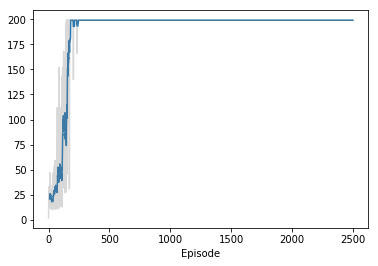

In [18]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0.5,0,'Episode')

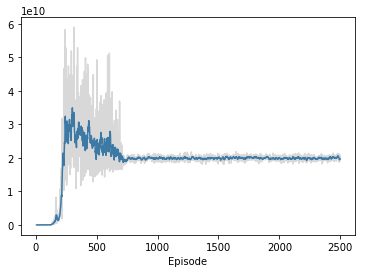

In [19]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
# plt.ylabel('Q losses')

Text(0.5,0,'Episode')

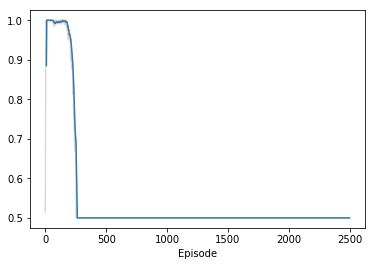

In [20]:
eps, arr = np.array(mean_qs_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
# plt.ylabel('Q losses')

Text(0.5,0,'Episode')

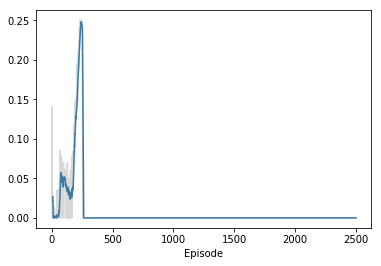

In [21]:
eps, arr = np.array(std_qs_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
# plt.ylabel('Q losses')

Text(0.5,0,'Episode')

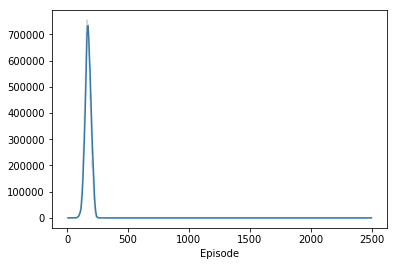

In [22]:
eps, arr = np.array(mean_Qs_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
# plt.ylabel('Q losses')

Text(0.5,0,'Episode')

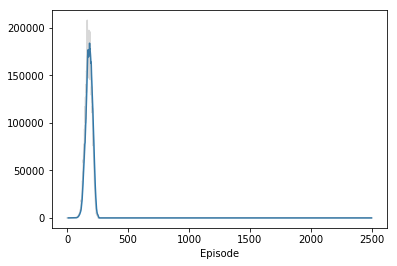

In [23]:
eps, arr = np.array(std_Qs_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
# plt.ylabel('Q losses')

Text(0.5,0,'Episode')

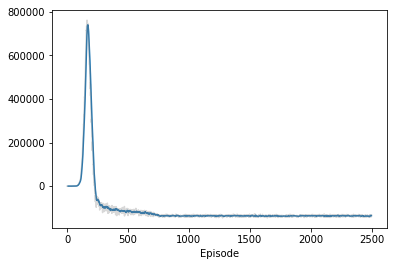

In [24]:
eps, arr = np.array(mean_nextQs_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
# plt.ylabel('Q losses')

Text(0.5,0,'Episode')

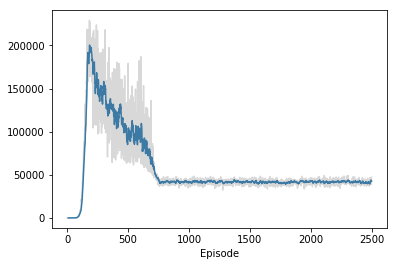

In [25]:
eps, arr = np.array(std_nextQs_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
# plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [25]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [26]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.